In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from scipy.stats.mstats import winsorize

In [2]:
df=pd.read_csv("C:\\Users\\bhask\\Downloads\\Apples_stock price dataset.csv",parse_dates=['timestamp'])
df

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 00:00:00,102.48,7984.16,2994.24,4.59,6.84,1.18,0.10
1,2010-01-01 01:00:00,99.35,7995.71,2995.83,2.63,5.85,1.92,-0.24
2,2010-01-01 02:00:00,103.32,8000.89,2998.12,2.62,6.24,2.44,-0.83
3,2010-01-01 03:00:00,107.73,7995.76,3004.53,3.12,6.40,2.37,0.06
4,2010-01-01 04:00:00,98.98,8002.45,2997.15,4.27,4.94,1.93,-0.22
...,...,...,...,...,...,...,...,...
99995,2021-05-29 11:00:00,498.72,507952.14,200804.70,3.82,3.62,3.32,-0.16
99996,2021-05-29 12:00:00,497.04,507943.81,200807.80,1.75,4.90,2.72,0.17
99997,2021-05-29 13:00:00,501.97,507932.52,200809.97,2.42,4.99,1.68,-0.48
99998,2021-05-29 14:00:00,498.91,507942.05,200807.35,2.79,5.86,1.08,0.40


Converts the timestamp column to datetime format

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

In [5]:
print(df['timestamp'].tail())

99995   2021-05-29 11:00:00
99996   2021-05-29 12:00:00
99997   2021-05-29 13:00:00
99998   2021-05-29 14:00:00
99999   2021-05-29 15:00:00
Name: timestamp, dtype: datetime64[ns]


Filters  data to include only U.S. stock market hours (4:00 AM to 8:00 PM ET, Monday to Friday).

In [7]:
df.isnull().sum()

timestamp             0
stock_price          31
nasdaq_index          7
sp500_index           4
inflation_rate        8
unemployment_rate     4
interest_rate         2
market_sentiment      4
dtype: int64

forward fill works by propagating the last known (non-null) value forward until a new value appears.

In [9]:
df['stock_price'].fillna(method='ffill', inplace=True)
df['nasdaq_index'].fillna(method='ffill', inplace=True)
df['nasdaq_index'].fillna(method='bfill', inplace=True)  # Handle start gaps
df['sp500_index'].fillna(method='ffill', inplace=True)
df['sp500_index'].fillna(method='bfill', inplace=True)  # Handle start gaps
df['inflation_rate'].fillna(method='ffill', inplace=True)
df["unemployment_rate"].fillna(df["unemployment_rate"].median(), inplace=True)
df[['interest_rate', 'market_sentiment']] = df[['interest_rate', 'market_sentiment']].apply(lambda x: x.fillna(x.median()))

In [10]:
df.isnull().sum()

timestamp            0
stock_price          0
nasdaq_index         0
sp500_index          0
inflation_rate       0
unemployment_rate    0
interest_rate        0
market_sentiment     0
dtype: int64

In [11]:
df=df.set_index('timestamp').between_time('04:00', '20:00').reset_index()#filtering the index and time between
# Exclude weekends
df=df[df['timestamp'].dt.dayofweek < 5]

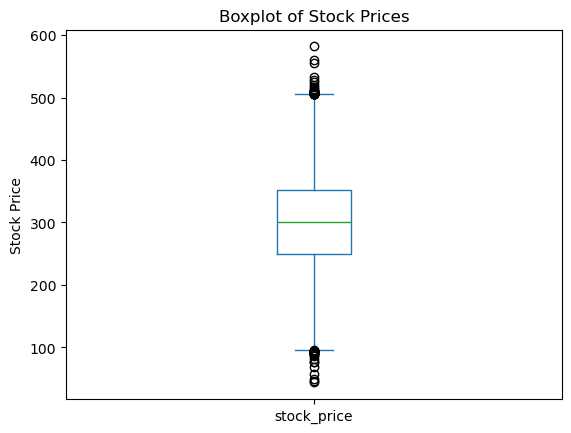

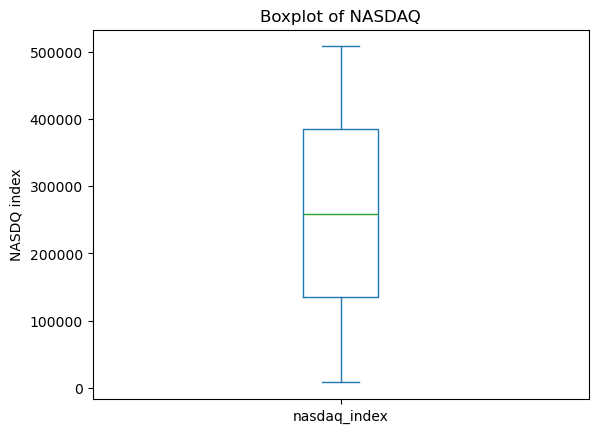

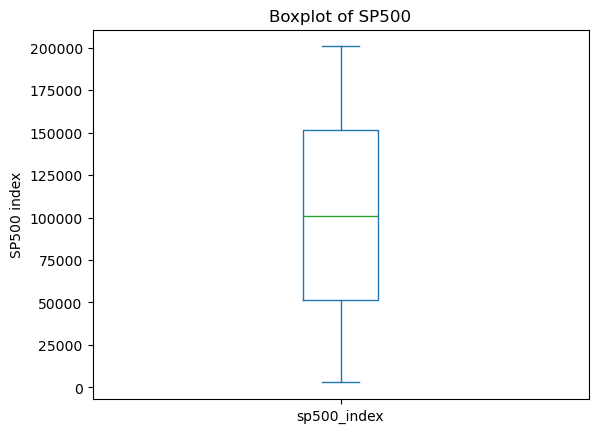

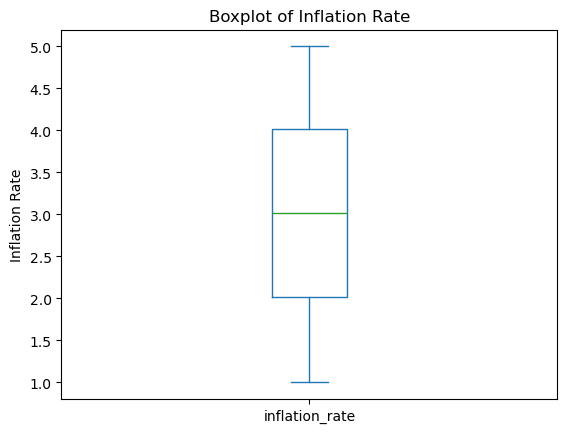

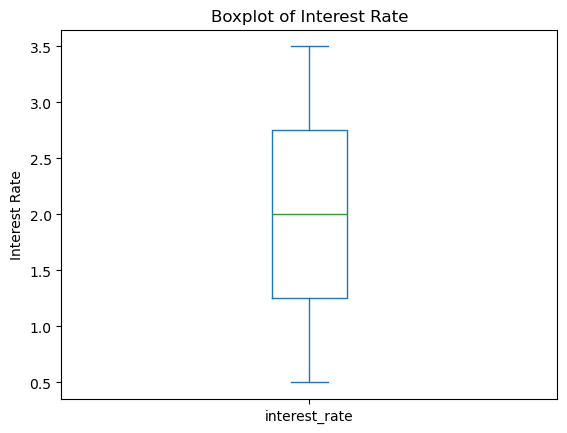

In [12]:
df["stock_price"].plot.box()
plt.title("Boxplot of Stock Prices")
plt.ylabel("Stock Price")
plt.show()
df["nasdaq_index"].plot.box()
plt.title("Boxplot of NASDAQ")
plt.ylabel("NASDQ index")
plt.show()
df["sp500_index"].plot.box()
plt.title("Boxplot of SP500")
plt.ylabel("SP500 index")
plt.show()
df["inflation_rate"].plot.box()  # Correct way to plot a boxplot for a Series
plt.title("Boxplot of Inflation Rate")
plt.ylabel("Inflation Rate")
plt.show()
df["interest_rate"].plot.box() 
plt.title("Boxplot of Interest Rate")
plt.ylabel("Interest Rate")
plt.show()

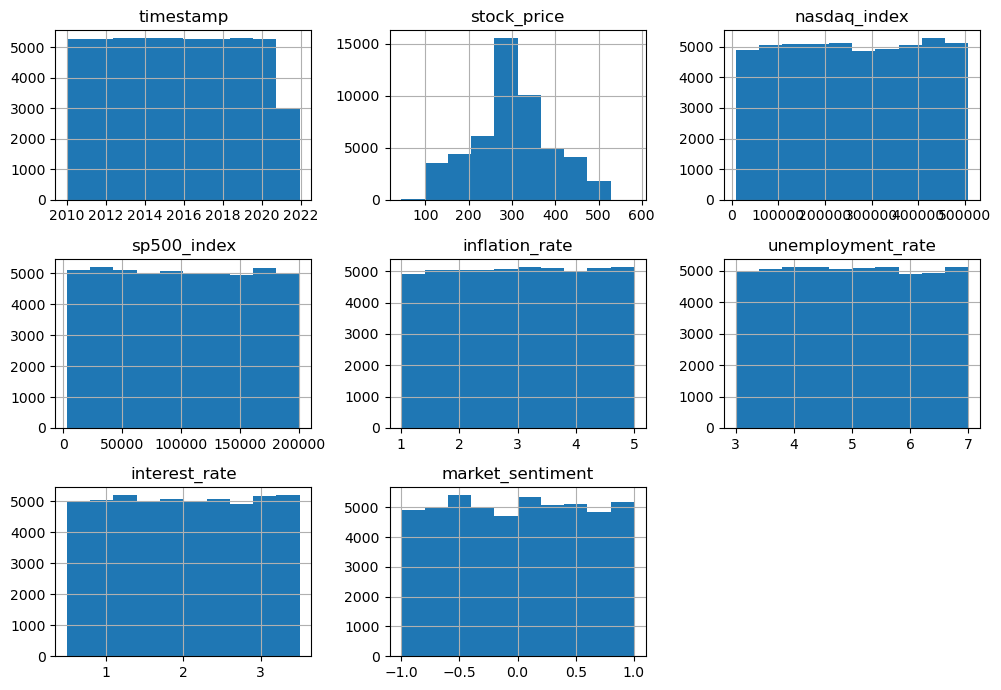

In [13]:
df.hist(figsize=(10,7))
plt.tight_layout()

In [14]:
for col in df.columns:
    print(f"{col}: {type(df[col].values)}")

timestamp: <class 'numpy.ndarray'>
stock_price: <class 'numpy.ndarray'>
nasdaq_index: <class 'numpy.ndarray'>
sp500_index: <class 'numpy.ndarray'>
inflation_rate: <class 'numpy.ndarray'>
unemployment_rate: <class 'numpy.ndarray'>
interest_rate: <class 'numpy.ndarray'>
market_sentiment: <class 'numpy.ndarray'>


In [15]:
df = df.fillna(0)

winsorize works replacing the  extreme values (outliers) with less extreme values.
    top 5% of values are replaced with the 5th percentile value.
    Bottom 5% of values are replaced with the 5th percentile value.

In [17]:
for col in ['stock_price', 'nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])
def replace_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std
    df[column] = np.where(df[column] > upper_bound, mean, df[column])
    df[column] = np.where(df[column] < lower_bound, mean, df[column])
    return df
outlier_col = ['stock_price', 'nasdaq_index', 'sp500_index']
for col in outlier_col:
    df = replace_outliers(df, col)
df.describe()

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArra

,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
count,50592.00000,50592.000000,50592.000000,50592.000000,50592.000000,50592.000000,50592.000000
mean,300.09031,259165.523846,101474.386989,3.008223,4.993750,2.000041,0.001311
std,87.94133,142399.507200,56449.646161,1.136711,1.137969,0.854907,0.569177
min,134.29000,33800.470000,13022.810000,1.210000,3.200000,0.650000,-0.900000
25%,248.96750,134942.727500,51697.220000,2.010000,4.000000,1.250000,-0.500000
50%,300.11000,257819.410000,100909.625000,3.010000,4.990000,2.000000,0.010000
75%,351.53250,385413.395000,151738.237500,4.010000,5.990000,2.750000,0.500000
max,465.68000,482664.400000,190581.210000,4.800000,6.800000,3.350000,0.900000


In [18]:
for col in ['stock_price', 'nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']:
    df = replace_outliers(df, col)

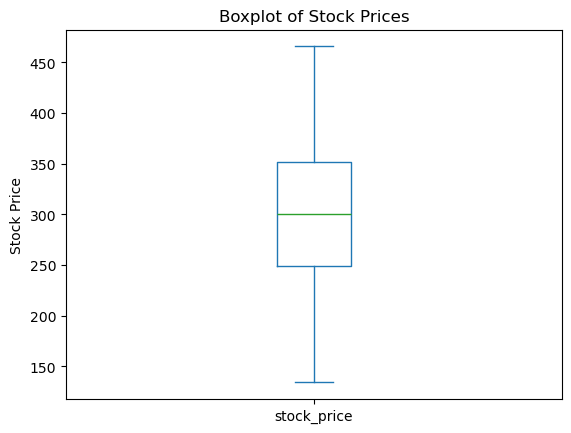

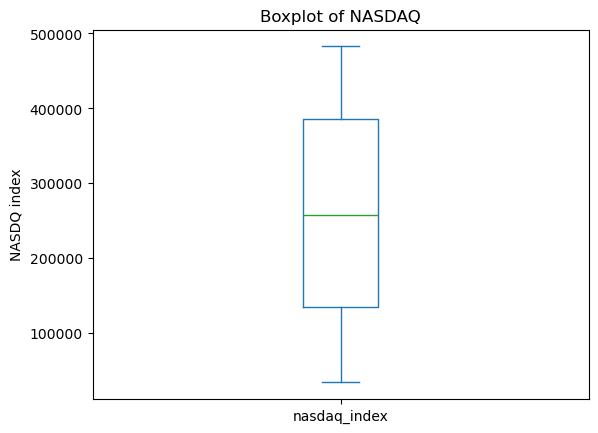

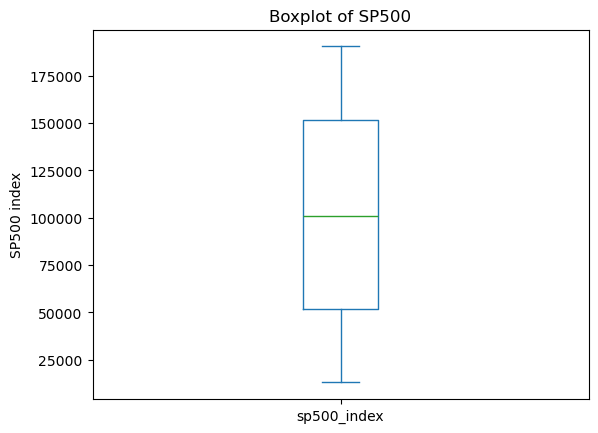

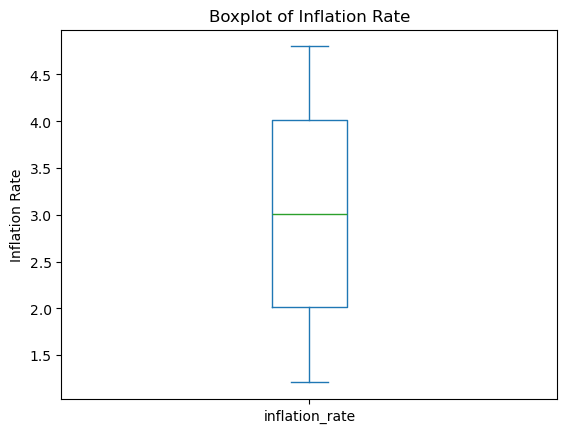

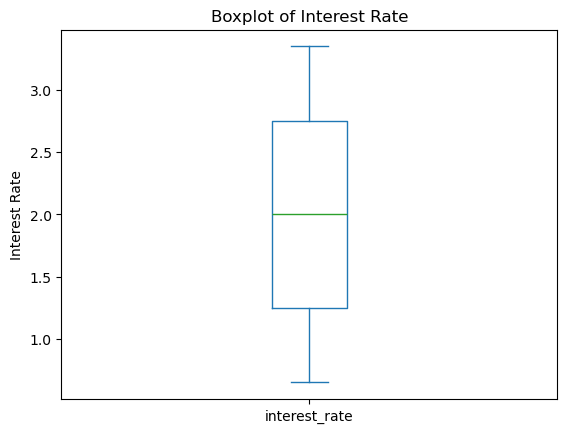

In [19]:
df["stock_price"].plot.box()
plt.title("Boxplot of Stock Prices")
plt.ylabel("Stock Price")
plt.show()
df["nasdaq_index"].plot.box()
plt.title("Boxplot of NASDAQ")
plt.ylabel("NASDQ index")
plt.show()
df["sp500_index"].plot.box()
plt.title("Boxplot of SP500")
plt.ylabel("SP500 index")
plt.show()
df["inflation_rate"].plot.box()  # Correct way to plot a boxplot for a Series
plt.title("Boxplot of Inflation Rate")
plt.ylabel("Inflation Rate")
plt.show()
df["interest_rate"].plot.box() 
plt.title("Boxplot of Interest Rate")
plt.ylabel("Interest Rate")
plt.show()

Text(0.5, 1.0, 'Apple Stock Price')

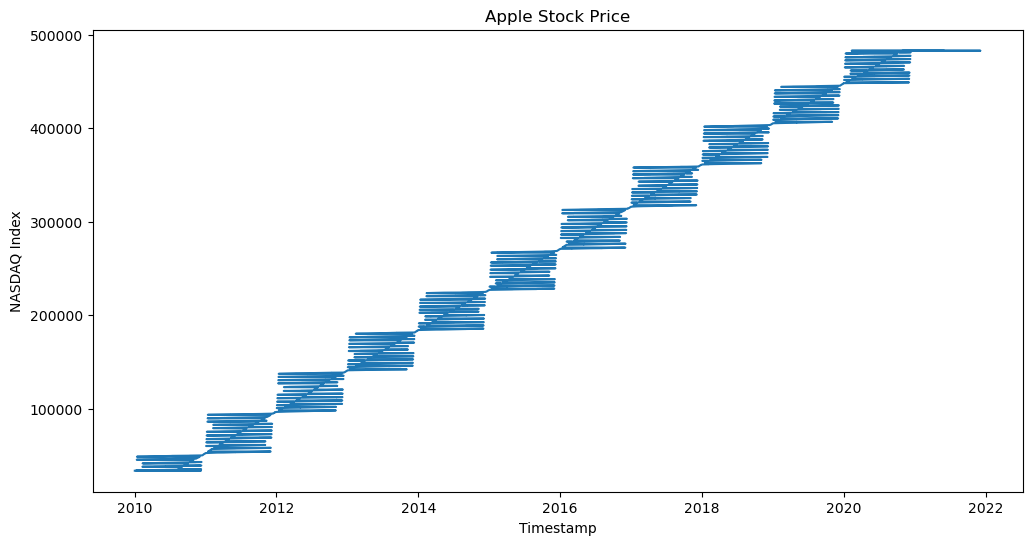

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['nasdaq_index'])
plt.xlabel('Timestamp')
plt.ylabel('NASDAQ Index')
plt.title("Apple Stock Price")

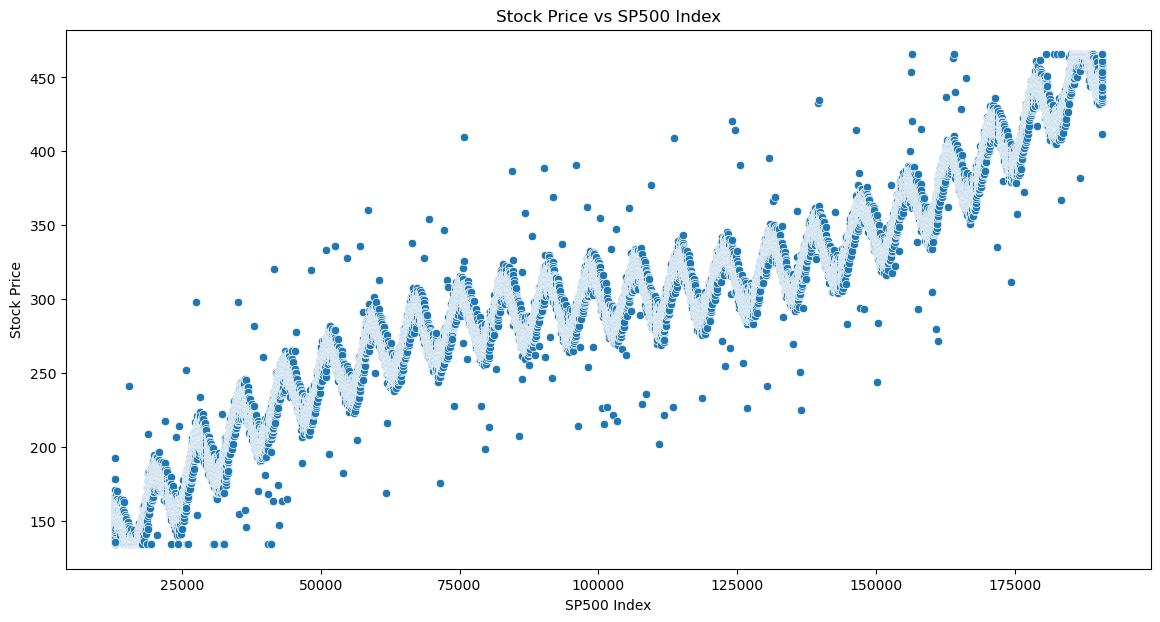

In [21]:
# Scatter plot of stock price vs SP500 index
plt.figure(figsize=(14, 7))
sns.scatterplot(x='sp500_index', y='stock_price', data=df)
plt.title('Stock Price vs SP500 Index')
plt.xlabel('SP500 Index')
plt.ylabel('Stock Price')
plt.show()


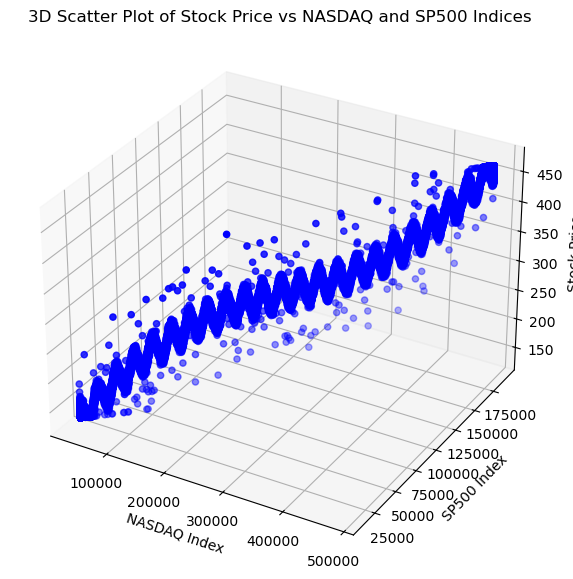

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['nasdaq_index'], df['sp500_index'], df['stock_price'], c='b', marker='o')
ax.set_xlabel('NASDAQ Index')
ax.set_ylabel('SP500 Index')
ax.set_zlabel('Stock Price')
plt.title('3D Scatter Plot of Stock Price vs NASDAQ and SP500 Indices')
plt.show()


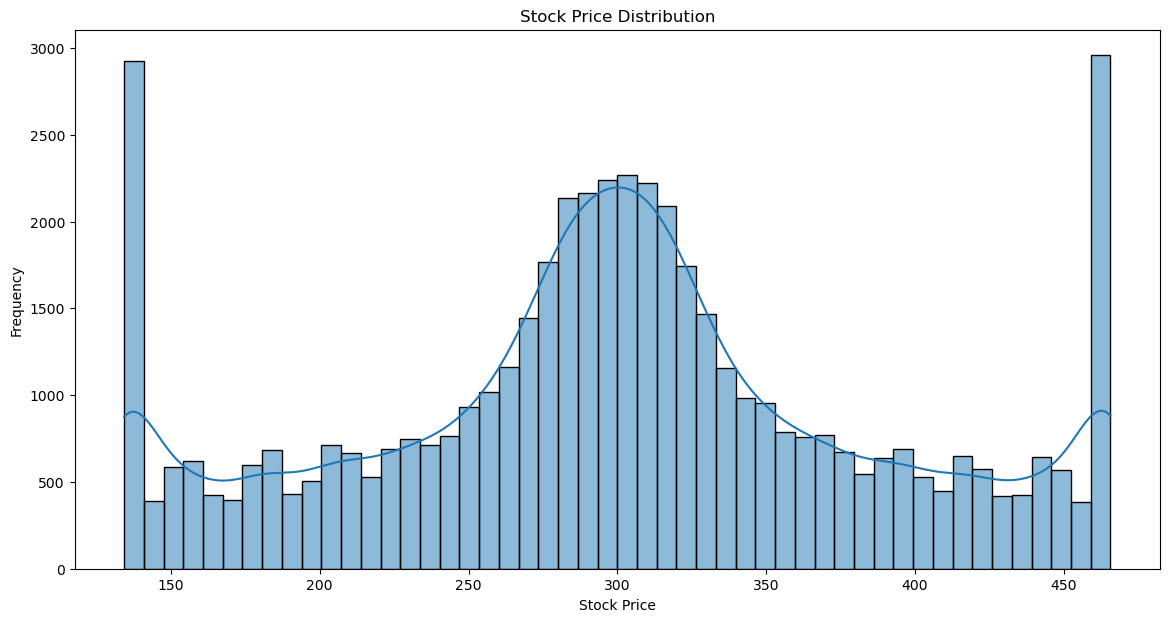

In [23]:
# Histogram of stock price distribution
plt.figure(figsize=(14, 7))
sns.histplot(df['stock_price'], bins=50, kde=True)
plt.title('Stock Price Distribution')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.show()

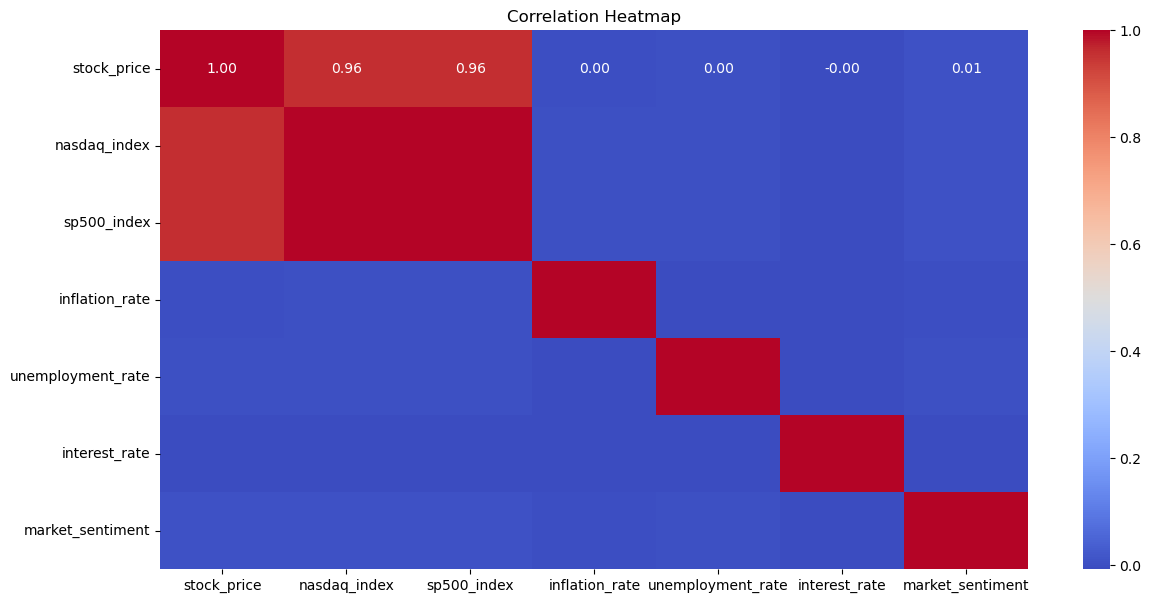

In [24]:
# Correlation heatmap
plt.figure(figsize=(14, 7))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [25]:
df.set_index('timestamp', inplace=True)
df = df.asfreq('B')  # Set frequency to business days
df.sort_index(inplace=True)  # Ensure chronological order

In [26]:
df.dropna(subset=['stock_price'], inplace=True)

In [27]:
result = adfuller(df['stock_price'])  
print(f'ADF Statistic: {result[0]}')  
print(f'p-value: {result[1]}')  

if result[1] > 0.05:
    print("Series is non-stationary. Applying differencing.")
    df['stock_price'] = df['stock_price'].diff().dropna()
else:
    print("Series is stationary. Proceed with modeling.")

ADF Statistic: -0.7097554811208773
p-value: 0.8442064401976419
Series is non-stationary. Applying differencing.


In [28]:
scaler = StandardScaler()
df['stock_price_scaled'] = scaler.fit_transform(df[['stock_price']])

In [29]:
df['stock_price_scaled'] = df['stock_price'].diff().dropna()

In [30]:
result = adfuller(df['stock_price_scaled'].dropna())  
print(f'ADF Statistic (Differenced): {result[0]}')  
print(f'p-value (Differenced): {result[1]}')  
if result[1] > 0.05:
    print("Still non-stationary. Consider higher-order differencing.")
else:
    print("Now stationary. Proceed with modeling.")

ADF Statistic (Differenced): -22.125556393618087
p-value (Differenced): 0.0
Now stationary. Proceed with modeling.


In [31]:
from pmdarima import auto_arima
auto_model = auto_arima(df['stock_price_scaled'].dropna(), seasonal=False, stepwise=True, trace=True)  
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=6.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27695.282, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26730.617, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=1.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26031.409, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=25257.418, Time=0.51 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=25034.138, Time=0.63 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=24942.667, Time=0.72 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=8.59 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=6.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=24944.667, Time=1.73 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0]          
Total fit time: 26.985 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2974
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -12465.333
Date:                Wed, 19 Mar 2025   AIC                          24942.667
Time:                        21:36:02   BIC                          24978.653
Sample:                             0   HQIC                         24955.617
                               - 2974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1650      0.012   -100.633      0.000      -1.188      -1.142
ar.L2         -1.1809      0.021    -55.576      0.000      -1.223      -1.139
ar.L3         -0.9305      0.024    -38.149      0.000      -0.978      -0.883
ar.L4         -0.4664      0.022    -20.992      0.000      -0.510      -0.423
ar.L5         -0.1758      0.016    -10.942      0.000      -0.207      -0.144
sigma2       256.0930      3.929     65.173      0.000     248.391     263.795
===================================================================================
Ljung-Box (L1) (Q):                   2.19   Jarque-Bera (JB):              3066.63
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.07
Prob(H) (two-sided):                  0.17   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
best_order = auto_model.order  # Extract best (p,d,q)
model = ARIMA(df['stock_price_scaled'].dropna(), order=best_order) 
model_fit = model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
# Print model summary to check for issues
print("Model summary:")
print(model_fit.summary())

Model summary:
                               SARIMAX Results                                
Dep. Variable:     stock_price_scaled   No. Observations:                 2974
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -12465.332
Date:                Wed, 19 Mar 2025   AIC                          24944.664
Time:                        21:36:05   BIC                          24986.648
Sample:                             0   HQIC                         24959.773
                               - 2974                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.060     -0.006      0.996      -0.118       0.118
ar.L1         -1.1650      0.012   -100.746      0.000      -1.188      -1.142
ar.L2         -1.1810      0.021    -

In [34]:
forecast_scaled = model_fit.forecast(steps=30)
forecast_scaled = np.array(forecast_scaled).reshape(-1, 1)  # Reshape for inverse transform
# Reverse scaling
forecast_original = scaler.inverse_transform(forecast_scaled)
# Create datetime index for forecasted dates
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=30, freq='B')
# Convert back to DataFrame
forecast_df = pd.DataFrame(forecast_original, index=forecast_index, columns=['Forecasted Price'])

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [35]:
forecast_df

,Forecasted Price
2021-12-03 04:00:00,0.084982
2021-12-06 04:00:00,0.115748
2021-12-07 04:00:00,0.111095
2021-12-08 04:00:00,0.104756
2021-12-09 04:00:00,0.101326
2021-12-10 04:00:00,0.107429
2021-12-13 04:00:00,0.107031
2021-12-14 04:00:00,0.107254
2021-12-15 04:00:00,0.104500
2021-12-16 04:00:00,0.105572


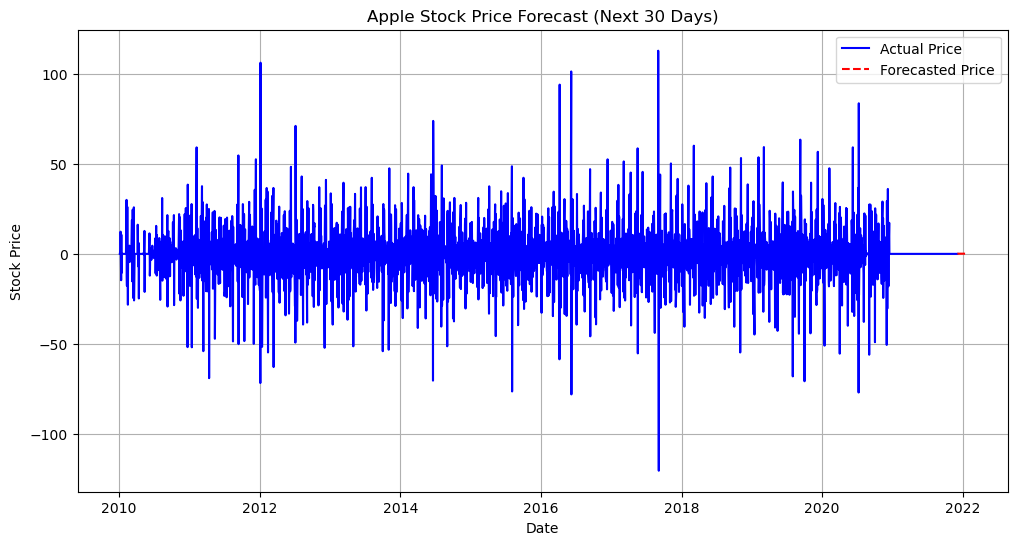

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['stock_price'], label='Actual Price', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecasted Price'], label='Forecasted Price', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Apple Stock Price Forecast (Next 30 Days)')
plt.legend()
plt.grid()
plt.show()

In [37]:
df.dropna(inplace=True)

In [38]:
X = df[['nasdaq_index','inflation_rate']]
y = df['stock_price']

Here, sp500_index and market_sentiment has the lower importance than others.

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

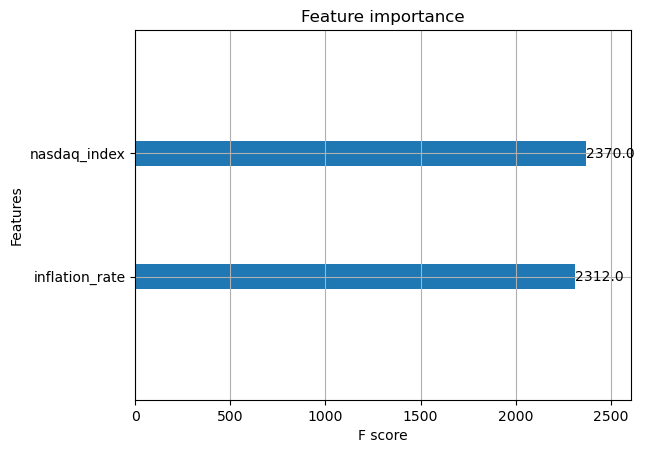

In [41]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgb.plot_importance(model)
plt.show()

In [42]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor()
random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=20, cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [44]:
best_model = xgb.XGBRegressor(subsample=1.0, n_estimators=200, max_depth=5, learning_rate=0.1, colsample_bytree=0.8, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 14.435350941549295
R² Score: 0.14691581405015786


RMSE is decreasing, and  R² is improving, but 0.085 is still quite low.We can choose another model for making acurate predictions this model isnt reliable yet doing.

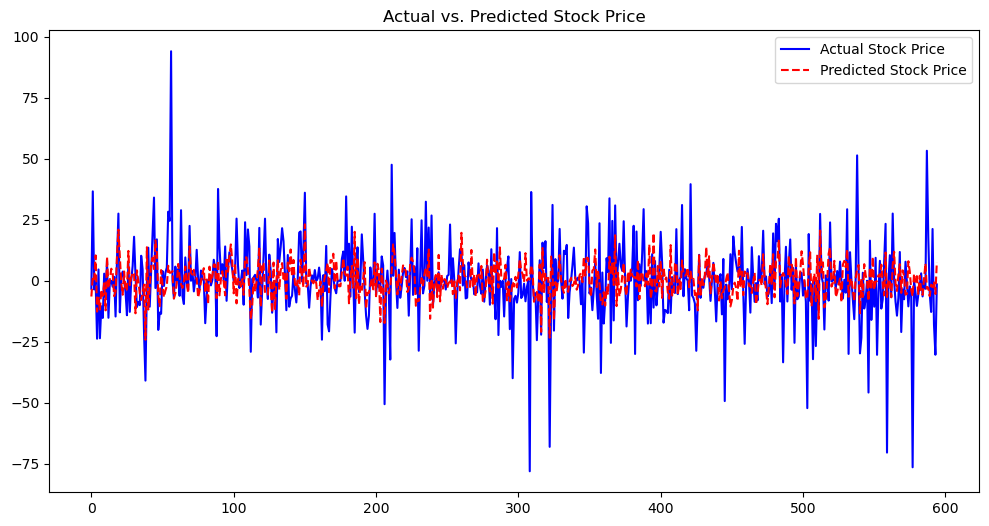

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Stock Price", color='blue')
plt.plot(y_pred, label="Predicted Stock Price", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs. Predicted Stock Price")
plt.show()

By adding lagged stock prices and moving averages can help capture trends and patterns in stock price movements

In [48]:
df['stock_price_lag1'] = df['stock_price'].shift(1)  # 1-day lag
df['stock_price_lag2'] = df['stock_price'].shift(2)  # 2-day lag
df['stock_price_lag3'] = df['stock_price'].shift(3)  # 3-day lag

Moving averages smooth fluctuations and highlight trends.

In [50]:
df['stock_price_ma7'] = df['stock_price'].rolling(window=7).mean()  # 7-day moving average
df['stock_price_ma30'] = df['stock_price'].rolling(window=30).mean()  # 30-day moving average

In [51]:
df = df.dropna()

In [52]:
from xgboost import XGBRegressor
X = df[['nasdaq_index', 'inflation_rate', 'stock_price_lag1', 'stock_price_lag2', 'stock_price_lag3', 
        'stock_price_ma7', 'stock_price_ma30']]
y = df['stock_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.5, colsample_bytree=1.0)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

RMSE: 10.166319255945401
R² Score: 0.5196301922947607


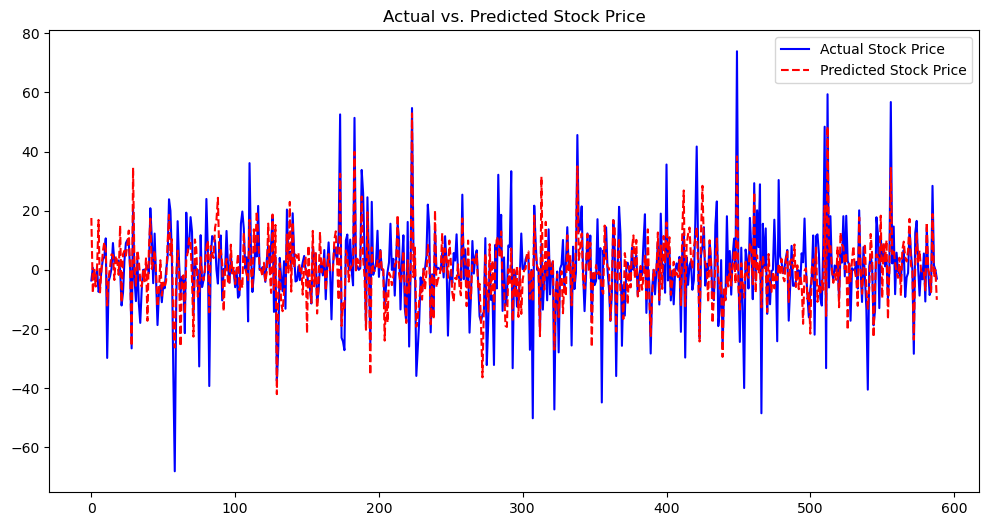

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Stock Price", color='blue')
plt.plot(y_pred, label="Predicted Stock Price", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs. Predicted Stock Price")
plt.show()

In [54]:
import lightgbm as lgb

In [55]:
X = df[['nasdaq_index', 'inflation_rate', 'stock_price_lag1', 'stock_price_lag2', 'stock_price_lag3', 
        'stock_price_ma7', 'stock_price_ma30']]
y = df['stock_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', 
                              objective='regression', 
                              metric='rmse',
                              n_estimators=500, 
                              learning_rate=0.2, 
                              max_depth=2)
lgb_model.fit(X_train, y_train, eval_metric='rmse')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1764
[LightGBM] [Info] Number of data points in the train set: 2356, number of used features: 7
[LightGBM] [Info] Start training from score 0.072110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor(learning_rate=0.2, max_depth=2, metric='rmse', n_estimators=500,
              objective='regression')

In [57]:
y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 10.79986866978906
R² Score: 0.4578928139848665


In [58]:
lgb_model.feature_importances_

array([207, 141, 272, 191, 184, 239, 216])

In [59]:
from sklearn.ensemble import RandomForestRegressor
X = df[['nasdaq_index', 'sp500_index','inflation_rate', 'unemployment_rate','interest_rate','market_sentiment']]
y = df['stock_price']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
RF = RandomForestRegressor(n_estimators=110, max_depth=6, random_state=101)
RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=110, random_state=101)

In [62]:
y_pred = RF.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 14.728978430294728
R² Score: -0.008308591859652825


In [63]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestRegressor(random_state=300)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=20, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
RMSE: 14.63566512645418
R² Score: 0.004426923246357406


The model explains only 0.44% of the variance in the target variable,indicating poor predictive performance.

In [65]:
auto_model = auto_arima(df['stock_price'], 
                        seasonal=True, 
                        m=30,  # Change based on your seasonality (e.g., 7 for daily, 12 for monthly)
                        trace=True,
                        suppress_warnings=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=52.85 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=24669.909, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=24426.659, Time=3.91 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=24105.668, Time=7.26 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=24668.032, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=24103.671, Time=1.22 sec
 ARIMA(0,0,1)(1,0,0)[30] intercept   : AIC=24105.669, Time=7.57 sec
 ARIMA(0,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=15.84 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=23906.286, Time=1.94 sec
 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=23908.234, Time=12.57 sec
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=23908.220, Time=11.60 sec
 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=24.02 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=24426.738, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=23908.109, Time=2.97 sec
 ARIMA(1,0,2)(0,0,

In [130]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Define the SARIMA model
model = SARIMAX(df['stock_price'], 
                order=(1, 0, 1),    # (p, d, q) from auto_arima
                seasonal_order=(1, 0, 1, 12),  # (P, D, Q, m) from auto_arima
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()
model_fit.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        stock_price   No. Observations:                 2945
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -11886.771
Date:                            Wed, 19 Mar 2025   AIC                          23783.542
Time:                                    21:42:00   BIC                          23813.457
Sample:                                         0   HQIC                         23794.315
                                           - 2945                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3961      0.016     24.793      0.000       0.365       0.427
ma.L1         -0.8949      0.010    -88.740      0.000      -0.915      -0.875
ar.S.L12       0.6766      0.084      8.073      0.000       0.512       0.841
ma.S.L12      -0.7613      0.072    -10.522      0.000      -0.903      -0.619
sigma2       194.2089      3.045     63.783      0.000     188.241     200.177
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2668.58
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.10
Prob(H) (two-sided):                  0.58   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = df['stock_price'][-30:]  # Last 30 actual values
y_pred = model_fit.forecast(steps=30)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 0.10
RMSE: 0.13


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
